<a href="https://colab.research.google.com/github/EricEricEricJin/ECE539-Group-Project/blob/master/music_speech_clf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Reference: [Classifying Music and Speech with Machine Learning](https://medium.com/m2mtechconnect/classifying-music-and-speech-with-machine-learning-e036ffab002e)

11/2 Update:
- Enabled variable input sample number
- Rewrote all code by myself in modern TF and Keras
- Tried majority-voting instead of FIR filter, and it works better, but FPR still too high.

- Next step: try vocal separation before feeding into NN.  


In [48]:
####################
# Import libraries #
####################

from google.colab import drive
drive.mount("/content/drive")

import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow.keras as keras

import os

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [49]:
#############################
# Load xxm_splitted dataset #
#############################

def get_waveforms_labels(fp, INPUT_SIZE):
  def _get_waveform(file_path):
    audio_binary = tf.io.read_file(file_path)
    audio, _ = tf.audio.decode_wav(audio_binary)
    return tf.squeeze(audio)

  def _get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2]

  waveforms = []
  labels = []
  for dirname, _, filenames in os.walk(fp):
      if "xxm_singing" in dirname or "xxm_speech" in dirname:
          print(dirname, filenames)
          for filename in filenames:
            filepath = os.path.join(dirname, filename)
            for i in range(661500 // INPUT_SIZE):
              waveforms.append(_get_waveform(filepath)[i*INPUT_SIZE : (i+1)*INPUT_SIZE])
              labels.append(_get_label(filepath))
  return waveforms, labels

CHUNK_SAMPLE = 661500 // 5

fp = "/content/drive/My Drive/Colab Notebooks/ECE539_Project"
categories = ["xxm_speech", "xxm_singing"]
waveforms, labels = get_waveforms_labels(fp, CHUNK_SAMPLE)

# Merge to tfds
_ds = tf.data.Dataset.from_tensor_slices((waveforms, labels))
waveform_ds = _ds.shuffle(buffer_size=len(_ds))

/content/drive/My Drive/Colab Notebooks/ECE539_Project/xxm_singing ['4.wav', '0.wav', '3.wav', '1.wav', '2.wav', '5.wav', '14.wav', '8.wav', '7.wav', '13.wav', '12.wav', '9.wav', '10.wav', '6.wav', '15.wav', '16.wav', '11.wav', '21.wav', '23.wav', '19.wav', '20.wav', '18.wav', '22.wav', '25.wav', '24.wav', '17.wav', '35.wav', '31.wav', '32.wav', '33.wav', '26.wav', '27.wav', '34.wav', '30.wav', '28.wav', '29.wav', '41.wav', '43.wav', '40.wav', '36.wav', '42.wav', '38.wav', '39.wav', '37.wav', '49.wav', '50.wav', '48.wav', '52.wav', '45.wav', '47.wav', '44.wav', '51.wav', '46.wav', '58.wav', '59.wav', '53.wav', '54.wav', '60.wav', '61.wav', '56.wav', '55.wav', '57.wav', '62.wav', '70.wav', '64.wav', '63.wav', '67.wav', '71.wav', '66.wav', '68.wav', '65.wav', '69.wav', '81.wav', '76.wav', '80.wav', '72.wav', '73.wav', '78.wav', '79.wav', '82.wav', '77.wav', '75.wav', '74.wav', '91.wav', '89.wav', '90.wav', '87.wav', '85.wav', '86.wav', '83.wav', '88.wav', '84.wav', '94.wav', '95.wav', '9

In [50]:
##########################
# Check waveform dataset #
##########################
import IPython

for i in waveform_ds.take(5):
  ret = IPython.display.Audio(i[0], rate=22050)
  print(i[1])
  IPython.display.display(ret)


tf.Tensor(b'xxm_speech', shape=(), dtype=string)


tf.Tensor(b'xxm_singing', shape=(), dtype=string)


tf.Tensor(b'xxm_speech', shape=(), dtype=string)


tf.Tensor(b'xxm_speech', shape=(), dtype=string)


tf.Tensor(b'xxm_singing', shape=(), dtype=string)


In [51]:
##########################
# Convert to spectrogram #
##########################

def get_spectrogram(waveform):
    spectrogram = tf.signal.stft(
        waveform, frame_length=255, frame_step=128)
    # removes the phase (we only care about the magnitude)
    spectrogram = tf.abs(spectrogram)
    return spectrogram

def get_spectrograms_labels(waveform, label):
  return tf.expand_dims(get_spectrogram(waveform), -1), tf.argmax(label == categories)

spectrogram_ds = waveform_ds.map(get_spectrograms_labels)
print(len(spectrogram_ds))

for i in spectrogram_ds:
  print(i[0].shape, i[1])
  break

1370
(1032, 129, 1) tf.Tensor(0, shape=(), dtype=int64)


In [52]:
batch_size = 32 # WTF?

train_ds, val_ds = keras.utils.split_dataset(spectrogram_ds, left_size=0.8)
train_ds = train_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)

for _ in spectrogram_ds.take(1):
  input_shape = _[0].shape

print('Input shape:', input_shape)

Input shape: (1032, 129, 1)


In [53]:
for i in train_ds.take(1):
  print(i[1])

tf.Tensor([0 1 1 1 0 1 0 1 1 0 0 1 1 0 0 0 1 1 0 1 0 0 0 0 0 0 1 1 0 0 0 1], shape=(32,), dtype=int64)


In [54]:
tf.keras.backend.clear_session()

norm_layer = keras.layers.Normalization()
norm_layer.adapt(spectrogram_ds.map(lambda x, _: x))


model = keras.models.Sequential()
model.add(keras.layers.Input(shape=input_shape))
model.add(keras.layers.Resizing(64, 64))
model.add(norm_layer)
model.add(keras.layers.Conv2D(32, 3, activation='relu'))
model.add(keras.layers.Conv2D(64, 3, activation='relu'))
model.add(keras.layers.MaxPooling2D())
model.add(keras.layers.Dropout(0.25))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(128, activation='relu'))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(2))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing (Resizing)         (None, 64, 64, 1)         0         
                                                                 
 normalization (Normalizati  (None, 64, 64, 1)         3         
 on)                                                             
                                                                 
 conv2d (Conv2D)             (None, 62, 62, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 60, 60, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2  (None, 30, 30, 64)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 30, 30, 64)        0

In [55]:
model.compile(optimizer="adam",
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics="accuracy")

EPOCHS = 16
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=8),
)

Epoch 1/16
35/35 [==============================] - 2s 32ms/step - loss: 0.2912 - accuracy: 0.9078 - val_loss: 0.2044 - val_accuracy: 0.9234
Epoch 2/16
35/35 [==============================] - 1s 20ms/step - loss: 0.1388 - accuracy: 0.9544 - val_loss: 0.1356 - val_accuracy: 0.9526
Epoch 3/16
35/35 [==============================] - 1s 21ms/step - loss: 0.0777 - accuracy: 0.9790 - val_loss: 0.1040 - val_accuracy: 0.9708
Epoch 4/16
35/35 [==============================] - 1s 21ms/step - loss: 0.0754 - accuracy: 0.9799 - val_loss: 0.1131 - val_accuracy: 0.9599
Epoch 5/16
35/35 [==============================] - 1s 20ms/step - loss: 0.0436 - accuracy: 0.9881 - val_loss: 0.1084 - val_accuracy: 0.9599
Epoch 6/16
35/35 [==============================] - 1s 21ms/step - loss: 0.0350 - accuracy: 0.9900 - val_loss: 0.0808 - val_accuracy: 0.9818
Epoch 7/16
35/35 [==============================] - 1s 20ms/step - loss: 0.0374 - accuracy: 0.9881 - val_loss: 0.0741 - val_accuracy: 0.9745
Epoch 8/16
35

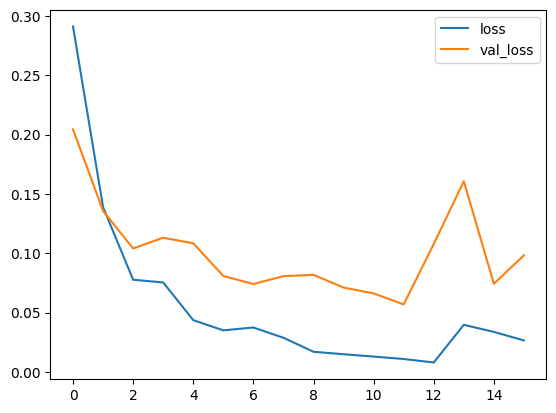

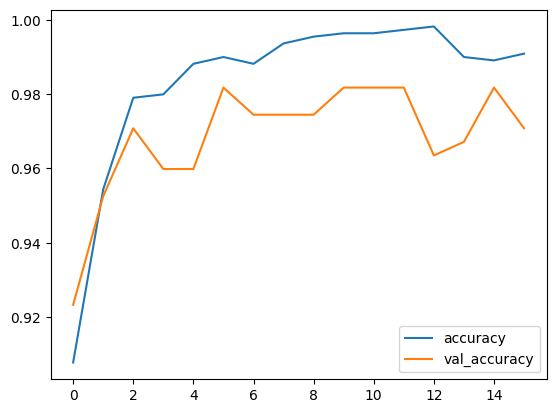

In [56]:
metrics = history.history
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()

metrics = history.history
plt.plot(history.epoch, metrics['accuracy'], metrics['val_accuracy'])
plt.legend(['accuracy', 'val_accuracy'])
plt.show()

## Apply to singing-speech mixed audio

In [57]:
BV1bT411S7ck = "/content/drive/My Drive/Colab Notebooks/ECE539_Project/xxm_mixed/BV1bT411S7ck.wav"

audio_binary = tf.io.read_file(BV1bT411S7ck)
audio, _ = tf.audio.decode_wav(audio_binary)
waveform = tf.squeeze(audio)


In [58]:
STEP_SIZE = CHUNK_SAMPLE // 2
len(waveform)

pred_list = []

model_input_list = []
for i in range((len(waveform) - CHUNK_SAMPLE) // STEP_SIZE + 1):
  wave_ith = waveform[i * STEP_SIZE : i * STEP_SIZE + CHUNK_SAMPLE]
  model_input_list.append(tf.expand_dims(get_spectrogram(wave_ith), -1))

In [59]:
# for i in range((len(waveform) - CHUNK_SIZE) // STEP_SIZE + 1):
#   wave_ith = waveform[i * STEP_SIZE : i * STEP_SIZE + CHUNK_SIZE]
#   # transfer to spectrum
#   spect = tf.expand_dims(get_spectrogram(wave_ith), -1)

#   model_input = tf.reshape(spect, (1, 5166, 129, 1))
#   pred = model.predict(model_input)
#   pred_list.append(pred)

pred_list = model.predict(tf.reshape(model_input_list, (len(model_input_list), *input_shape)))
pred_list.shape

106/106 [==============================] - 1s 9ms/step


(3369, 2)

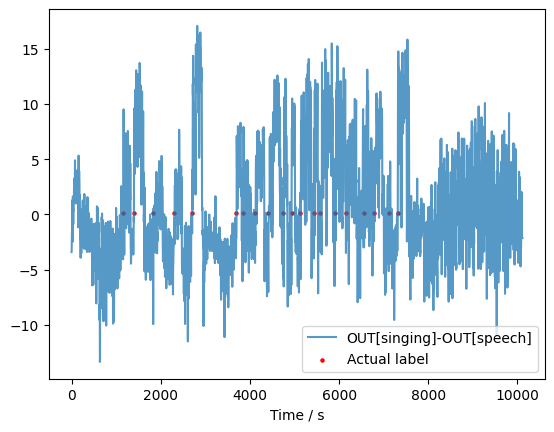

In [60]:
marker = np.loadtxt(
    "/content/drive/My Drive/Colab Notebooks/ECE539_Project/xxm_mixed/BV1bT411S7ck.csv",
    delimiter=',')
marker

marker = marker[:,0] * 3600 + marker[:,1] * 60 + marker[:,2]
marker

plt.xlabel("Time / s")

plt.plot(np.linspace(0, 10111, len(pred_list)), pred_list[:,1] - pred_list[:,0], alpha=0.75, label="OUT[singing]-OUT[speech]")
plt.scatter(marker, np.zeros(len(marker)) + 0.1, c='r', s=5, label="Actual label")
plt.legend()
plt.show()

In [61]:
pred_list[0:5]

array([[ 1.4734293 , -1.9292235 ],
       [ 1.403664  , -1.9420594 ],
       [ 1.0140705 , -1.2946013 ],
       [ 0.7852102 , -0.91879076],
       [ 0.5364037 , -0.83408004]], dtype=float32)

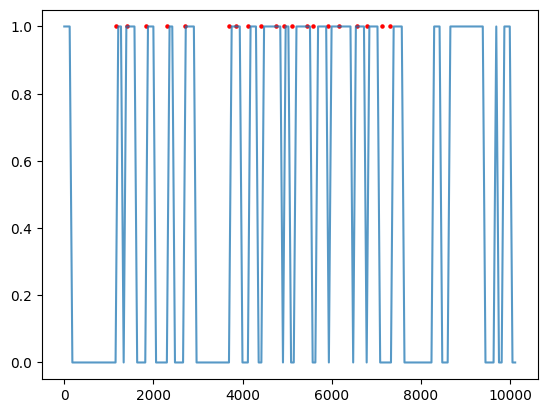

In [62]:
#########################
# Apply majority voting #
#########################

MV_PTS = 20

mv_list = []
for i in range(0, len(pred_list) - MV_PTS + 1, MV_PTS):
  if (pred_list[i : i+MV_PTS, 1] - pred_list[i : i+MV_PTS, 0] > 0).sum() > MV_PTS / 2:
    mv_list.append(1)
  else:
    mv_list.append(0)
mv_list = np.array(mv_list)

threshold = 0
plt.plot(np.linspace(0, 10111, len(mv_list)), mv_list, alpha=0.75, label="pred")
plt.scatter(marker, np.ones(len(marker)), c='r', s=5, label="Actual label")